In [1]:
import torch
import einops

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import itertools

from utils.components import *
from utils.config import *
from utils.einmask import EinMask
from utils.dataset import NinoData

from utils.masking import *

from omegaconf import OmegaConf
from dataclasses import replace

import torch_harmonics

In [2]:
cfg_file = OmegaConf.load('mae.yaml')
config = MTMConfig.from_omegaconf(cfg_file['defaults'])

In [ ]:
class SphericalDiffusionNoise(torch.nn.Module):
    def __init__(
            self,
            num_channels: int,
            nsteps: int = 36,
            nlat: int = 180,
            nlon: int = 360,
            sigma=1.0,
            kT=0.5 * (500.0 / 6370.0) ** 2,
            lambd=1.0,
            grid_type="equiangular",
            lat_slice=slice(58, 122, 1),
            lon_slice=slice(90,330,2),
        ):
        """
        A Random Field derived from a gaussian Diffusion Process on the sphere:

        For details see https://www.ecmwf.int/sites/default/files/elibrary/2009/11577-stochastic-parametrization-and-model-uncertainty.pdf,
        appendix 8.1.
        """
        super().__init__()
        #regional slices
        self.lat_slice = default(lat_slice, slice(0, nlat, 1))
        self.lon_slice = default(lon_slice, slice(0, lon_slice, 1))

        # Number of latitudinal modes.
        self.nlat = nlat
        self.nlon = nlon
        self.nsteps = nsteps
        self.num_channels = num_channels

        # Inverse SHT
        self.isht = torch_harmonics.InverseRealSHT(self.nlat, self.nlon, grid=grid_type)
        self.lmax_local = self.isht.lmax
        self.mmax_local = self.isht.mmax
        self.nlat_local = self.nlat
        self.nlon_local = self.nlon

        self.lmax = self.isht.lmax
        self.mmax = self.isht.mmax      

        # make sure kT is a torch.Tensor
        if isinstance(kT, list):
            kT = torch.as_tensor(kT)
            assert len(kT.shape) == 1
            assert kT.shape[0] == num_channels
        else:
            kT = torch.as_tensor([kT]).repeat(num_channels)
        kT = kT.reshape(self.num_channels, 1)
        # same for lambd
        if isinstance(lambd, list):
            lambd = torch.as_tensor(lambd)
            assert len(lambd.shape) == 1
            assert lambd.shape[0] == num_channels
        else:
            lambd = torch.as_tensor([lambd]).repeat(num_channels)
        lambd = lambd.reshape(self.num_channels, 1)

        ls = torch.arange(self.lmax)
        ektllp1 = torch.exp(-kT * ls * (ls + 1))
        F0norm = torch.sum((2 * ls[1:] + 1) * ektllp1[..., 1:], dim=-1, keepdim=True)
        phi = torch.exp(-lambd)
        F0 = sigma * torch.sqrt(0.5 * (1 - phi**2) / F0norm)
        sigma_l = F0 * torch.exp(-0.5 * kT * ls * (ls + 1))
        # we multiply by 4 pi to get the correct variance. Check ECMWF docs and their Spherical Harmonic normalization
        sigma_l = torch.tensor(4 * torch.pi).sqrt() * sigma_l

        # we need the toeplitz matrix for the discounts:
        #            [    1,     0,   0, 0]
        # discount = [  phi,     1,   0, 0]
        #            [phi^2,   phi,   1, 0]
        #            [phi^3, phi^2, phi, 1]
        disc = phi.pow(torch.arange(self.nsteps))
        disc_flipped = disc.flip(dims = (1,)) # reversed order
        zero_padding = torch.zeros_like(disc)[:, 1:]
        flat = torch.cat([disc_flipped, zero_padding], dim = 1)
        toeplitz = flat.unfold(dimension = 1, size = self.nsteps, step = 1)
        discount = toeplitz.flip(dims = (1,)) # reversed strides

        # expand and register
        phi = einops.repeat(phi, 'c 1 -> c t l m u', t = self.nsteps, l = self.lmax_local, m = self.mmax_local, u = 2)
        sigma_l = einops.repeat(sigma_l, 'c l -> c t l m u', t = self.nsteps, l = self.lmax_local, m = self.mmax_local, u = 2)
        self.register_buffer("phi", phi, persistent=False)
        self.register_buffer("sigma_l", sigma_l, persistent=False)
        self.register_buffer("discount", discount, persistent=False)

    def forward(self, shape, rng = None):
        with torch.no_grad():
            with torch.amp.autocast(device_type="cuda", enabled=False):
                eta_l = torch.empty(
                    (*shape, self.num_channels, self.nsteps, self.lmax_local, self.mmax_local, 2), 
                    dtype=torch.float32, device=self.phi.device
                    )
                state = self.sigma_l * eta_l.normal_(generator = rng)
                # the very first element in the time history requires a different weighting to sample the stationary distribution
                state[..., 0, :, :, :] = state[..., 0, :, :, :] / torch.sqrt(1.0 - self.phi[..., 0, :, :, :]**2)
                # get the right history by multiplying with the discount matrix
                state = torch.einsum("ctr, ...crlmu-> ...ctlmu", self.discount, state).contiguous()
                # inverse SHT
                cstate = torch.view_as_complex(state)
                eta = self.isht(cstate)
                # slice the region of interest
                eta = eta[..., self.lat_slice, self.lon_slice] 
        return eta

In [122]:
kT = einops.repeat(torch.as_tensor([1e-3, 5e-2, 1e-2]), 'k -> (k l)', l = 3, k = 3)
lambd = einops.repeat(torch.as_tensor([0.32, 0.16, 0.08]), 'l -> (k l)', l = 3, k = 3)


In [124]:
dn = SphericalDiffusionNoise(len(kT), lambd=lambd.tolist(), kT = kT.tolist())
dn = dn.to('cpu')

In [125]:
state = dn((10,))

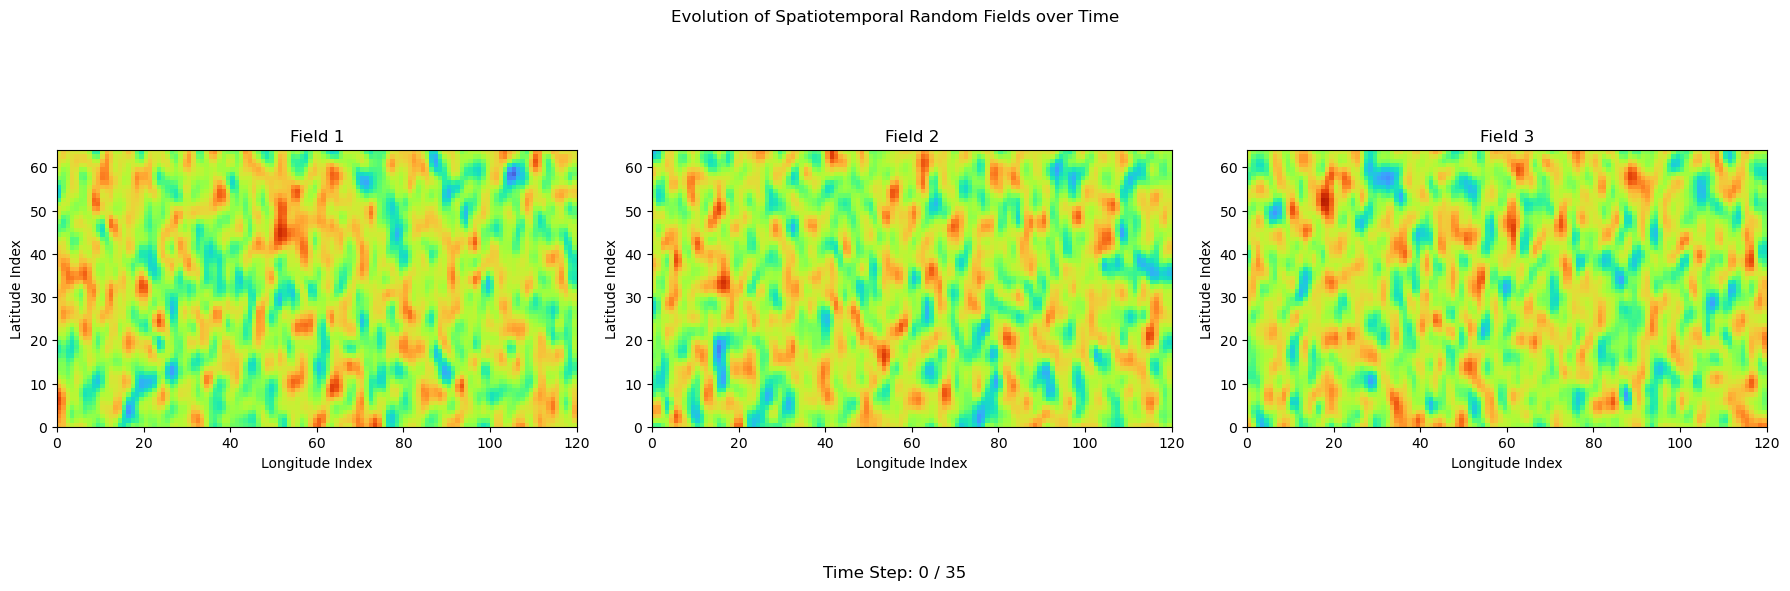

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

num_fields = 3

x = np.linspace(0, dn.nlon)
y = np.linspace(0, dn.nlat)
X, Y = np.meshgrid(x, y)
T = np.linspace(0, dn.nsteps)

state_to_animate = state.numpy()[0, :num_fields]

fig, axes = plt.subplots(1, num_fields, figsize=(6 * num_fields, 6)) 
plt.suptitle('Evolution of Spatiotemporal Random Fields over Time')

plots = []
v_min_global = state_to_animate.min()
v_max_global = state_to_animate.max()

for i in range(num_fields):
    ax = axes[i]

    mesh = ax.pcolormesh(
        state_to_animate[i, 0, :, :],
        vmin=v_min_global,
        vmax=v_max_global,
        shading='auto',
        cmap='turbo'
    )
    ax.set_title(f'Field {i+1}')
    ax.set_xlabel('Longitude Index')
    ax.set_ylabel('Latitude Index')
    ax.set_aspect('equal', adjustable='box') # Keep the spatial aspect ratio 
    
    plots.append(mesh)

time_text = fig.text(0.5, 0.04, f'Time Step: 0 / {dn.nsteps - 1}', 
                     ha='center', va='center', fontsize=12)


def update(frame):
    for i in range(num_fields):
       data = state_to_animate[i, frame, :, :]
       plots[i].set_array(data)
        
    time_text.set_text(f'Time Step: {frame} / {dn.nsteps - 1}')
    return plots + [time_text] 

ani = FuncAnimation(
    fig, 
    update, 
    frames=dn.nsteps, 
    interval=200, 
    blit=False,
    repeat=True 
)

plt.tight_layout(rect=[0, 0.08, 1, 1]) 

In [127]:
HTML(ani.to_jshtml())

In [9]:
from einops.layers.torch import EinMix
import einops

In [10]:
nemb = EinMix('b (t tt) k (h hh) (w ww) -> b (v t h w) d', weight_shape= 'v k tt hh ww d',
              h = 64//4, w=120//4, hh = 4, ww= 4, t = 6, tt = 6, v = 5, k = 8, d = 256)

In [11]:
nemb(noise).shape

torch.Size([10, 14400, 256])

In [12]:
def xr_pcc(pred: xr.DataArray, obs: xr.DataArray, dim: tuple[str]):
        num = (pred * obs).sum(dim)
        denom = np.sqrt((pred**2).sum(dim)) * np.sqrt((obs**2).sum(dim))
        return num / denom

In [13]:
ds = NinoData(config.trainer.godas_path, config.data)

In [14]:
ds.dataset.lon

<xarray.DataArray 'lon' (lon: 120)> Size: 960B
array([ 90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108., 110., 112.,
       114., 116., 118., 120., 122., 124., 126., 128., 130., 132., 134., 136.,
       138., 140., 142., 144., 146., 148., 150., 152., 154., 156., 158., 160.,
       162., 164., 166., 168., 170., 172., 174., 176., 178., 180., 182., 184.,
       186., 188., 190., 192., 194., 196., 198., 200., 202., 204., 206., 208.,
       210., 212., 214., 216., 218., 220., 222., 224., 226., 228., 230., 232.,
       234., 236., 238., 240., 242., 244., 246., 248., 250., 252., 254., 256.,
       258., 260., 262., 264., 266., 268., 270., 272., 274., 276., 278., 280.,
       282., 284., 286., 288., 290., 292., 294., 296., 298., 300., 302., 304.,
       306., 308., 310., 312., 314., 316., 318., 320., 322., 324., 326., 328.])
Coordinates:
  * lon       (lon) float64 960B 90.0 92.0 94.0 96.0 ... 322.0 324.0 326.0 328.0
    variable  <U12 48B 'temp_ocn_0a'

In [15]:
nino34 = ds.dataset['temp_ocn_0a'].sel(lon=slice(160, 210), lat=slice(-5, 5)).mean(dim=['lon', 'lat'])#.rolling(time = 3).mean()
nino34_smooth = ds.dataset['temp_ocn_0a'].sel(lon=slice(160, 210), lat=slice(-5, 5)).mean(dim=['lon', 'lat']).rolling(time = 3).mean()

In [16]:
ls = np.linspace(0,1, 11)
id = np.argwhere(ls > 0.5).max(initial= 0)
print(float(id))

10.0


In [17]:
pcc = xr_pcc(ds.dataset['temp_ocn_0a'], ds.dataset['temp_ocn_0a'].rolling(time=3).mean(), 'time')

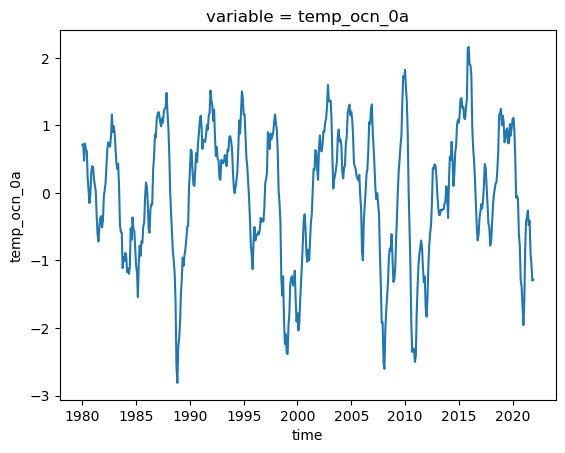

In [18]:
nino34.plot()

In [19]:
ds.dataset

<xarray.Dataset> Size: 155MB
Dimensions:       (time: 504, lat: 64, lon: 120)
Coordinates:
  * time          (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2021-12-01
  * lat           (lat) float64 512B -31.0 -30.0 -29.0 -28.0 ... 30.0 31.0 32.0
  * lon           (lon) float64 960B 90.0 92.0 94.0 96.0 ... 324.0 326.0 328.0
    month         (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12
    variable      <U12 48B 'temp_ocn_0a'
Data variables:
    temp_ocn_0a   (time, lat, lon) float64 31MB 0.9376 0.8365 ... 0.08766 0.1493
    temp_ocn_3a   (time, lat, lon) float64 31MB 1.826 1.918 ... -0.01389 0.05493
    temp_ocn_8a   (time, lat, lon) float64 31MB 1.047 1.032 ... 0.1945 0.3425
    temp_ocn_14a  (time, lat, lon) float64 31MB 2.268 2.347 ... -0.1503 0.0379
    tauxa         (time, lat, lon) float64 31MB -0.1726 -0.2267 ... 0.2099

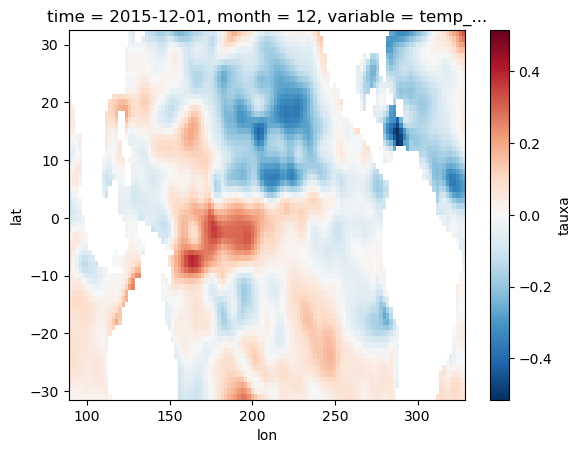

In [20]:
ds.dataset['tauxa'].sel(time='2015-12-01').plot()

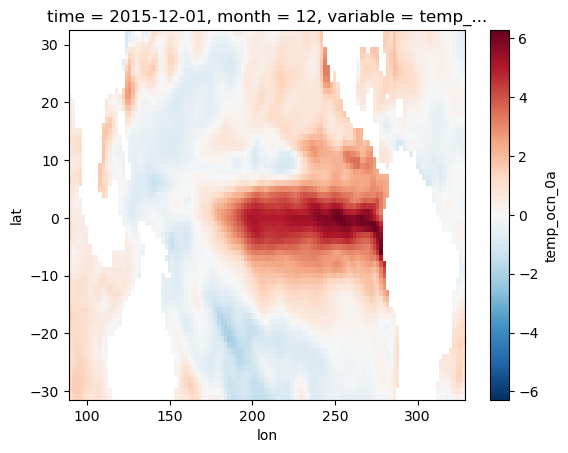

In [21]:
ds.dataset['temp_ocn_0a'].sel(time='2015-12-01').plot()